# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
# number of callbacks for black-sounding names
sum(data[data.race=='w'].call)

235.0

In [4]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


#### 1. What test is appropriate for this problem? Does CLT apply?

From our data set, we want to answer, "Is there a difference in number of callbacks between black and white people for the job search?" The Null Hypothesis Test appropriate for this problem given our data is a difference in proportion between black and white job seekers. To answer this question more appropriately for this problem, I will rephrase this question as, "Is there a proportional difference in callbacks between black job seekers and white job seekers?" Since we are looking at the proportional difference between the two groups, the Central Limit Theorem doesn't really help us here. Instead, we are going to look at if there are greater than 10 individuals per group and decide whether our normality assumptions apply from there.

#### 2. What are the null and alternate hypotheses?

The Null Hypothesis that we are trying to test is that there is no proportional difference in callbacks between black people and white people when it comes to the job search. Our Alternative Hypothesis is that there is a proportional difference in callbacks between the two races. Put succinctly:

$H$<sub>0</sub> : $p = 0$

$H$<sub>a</sub> : $p \neq 0$

$p = p(black) - p(white)$


In [5]:
w = data[data.race=='w']
b = data[data.race=='b']

#### 3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.

##### a. Answering Our Question Using the Bayesian Approach

In [6]:
counts = data.groupby(['race', 'call'])['call'].count()
counts

race  call
b     0.0     2278
      1.0      157
w     0.0     2200
      1.0      235
Name: call, dtype: int64

In [7]:
# Convert the counts series into a working_data DataFrame indexed by race and callback
index = pd.MultiIndex.from_product([['b','w'], ['No','Yes']],
                                  names=['race','call'])
working_data = pd.DataFrame(counts.values, index=index, columns=['count'])

''' Find the proportion of callbacks for each race by dividing values from the count column 
    by the total count of each race in the DataFrame '''
total_count = working_data.groupby('race')['count'].sum()
working_data['proportion'] = 0
working_data.loc['b', 'proportion'] = round(working_data.loc[:,'count'] / total_count['b'], 4)
working_data.loc['w', 'proportion'] = round(working_data.loc[:,'count'] / total_count['w'], 4)

working_data

count  proportion
race call                   
b    No     2278      0.9355
     Yes     157      0.0645
w    No     2200      0.9035
     Yes     235      0.0965

In [8]:
# Find variance for black and white applicants separately
var_black = working_data.loc[('b','Yes'), 'proportion']*working_data.loc[('b','No'), 'proportion']/total_count['b']
var_white = working_data.loc[('w','Yes'), 'proportion']*working_data.loc[('w','No'), 'proportion']/total_count['w']

# Find the joint proportion differences and standard errors
p_diff = working_data.loc[('b','Yes'), 'proportion'] - working_data.loc[('w','Yes'), 'proportion']
std_err = np.sqrt(var_black + var_white)

# Print Results
print(f' The observed proportional difference between the two groups is {p_diff*100:.2f}%')
print(f' The observed standard error between the two groups is {std_err*100:.2f}%')

 The observed proportional difference between the two groups is -3.20%
 The observed standard error between the two groups is 0.78%


In [17]:
# Center the proportional difference around zero difference
p_not = 0

# Find the margin of error for a 95% confidence interval
margin_error = 1.96 * std_err

# Find the confidence interval using our margin of error
confidence_interval_b = np.empty(2)
confidence_interval_b[0] = p_not - margin_error
confidence_interval_b[1] = p_not + margin_error

# Find the z-score for our observation given that our hypothesis is true
obs_z_score = (p_diff - p_not) / std_err

# Print the results
print(f' The margin of error is {margin_error*100:.2f}%')
print(f' The 95% confidence interval is between {confidence_interval_b[0]*100:.2f}% and {confidence_interval_b[1]*100:.2f}%')
print(f' Our observation is {obs_z_score:.2f} standard errors away from our hypothesized difference.')

 The margin of error is 1.53%
 The 95% confidence interval is between -1.53% and 1.53%
 Our observation is -4.11 standard errors away from our hypothesized difference.


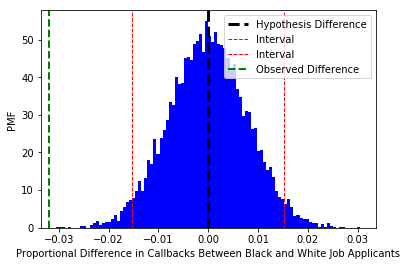

In [10]:
np.random.seed(42)

# Create 10,000 normally distributed  samples centered around the proposed mean and spread given our standard error
bins = 100
samples = np.random.normal(p_not, std_err, 10000)

# Plot the generated points as a histogram with markers indicating confidence interval, mean, and observation
_ = plt.hist(samples, bins=bins, density=True, color='blue')
_ = plt.axvline(p_not, color='black', linestyle='dashed', linewidth=3)
_ = plt.axvline(confidence_interval_b[0], color='red', linestyle='dashed', linewidth=1)
_ = plt.axvline(confidence_interval_b[1], color='red', linestyle='dashed', linewidth=1)
_ = plt.axvline(p_diff, color='green', linestyle='dashed', linewidth=2)
_ = plt.xlabel('Proportional Difference in Callbacks Between Black and White Job Applicants')
_ = plt.ylabel('PMF')
_ = plt.legend(('Hypothesis Difference', 'Interval', 'Interval', 'Observed Difference'), loc='upper right')
plt.show()

##### b. Answering Our Question Using the Frequentist Approach

In [26]:
# Create boolean arrays with True being number of callbacks and False being no callbacks
b_apps = np.array([True] * int(working_data.loc[('b','Yes'), 'count']) 
                  + [False] * int(working_data.loc[('b','No'), 'count']))
w_apps = np.array([True] * int(working_data.loc[('w','Yes'), 'count']) 
                  + [False] * int(working_data.loc[('w','No'), 'count']))

size = 10000
replicates = np.empty(size)
for i in range(size):
    
    # Generate a combined permutation from the original data
    combined = np.concatenate((b_apps, w_apps))
    combined = np.random.permutation(combined)
    
    # Split the data into a sample of black applicants and a sample of white applicants
    b_sample = combined[:len(b_apps)]
    w_sample = combined[len(b_apps):]
    
    # Generate a replicate proportion between the black applicants that got a callback and the total black applicants 
    replicate = np.sum(b_sample) / len(b_sample)
    
    # Add the replicate to the replicate array
    replicates[i] = replicate


confidence_interval_f = np.percentile(replicates, [2.5, 97.5])

'''Find the p-value by comparing the number of replicates with a proportion less than our 
   observed number of black acceptances to the total number of replicates we generated '''
replicates_mean = np.mean(replicates)
replicates_std = np.std(replicates)
p_value = np.sum(replicates <= working_data.loc[('b','Yes'), 'proportion']) / len(replicates)

# Print the results
obs_callback = working_data.loc[('b','Yes'), 'proportion']
print(f' The observed callback rate for black applicants is {obs_callback*100:.2f}%')
print(f' The average callback rate for black applicants is {replicates_mean*100:.2f}%')
print(f' The standard error for this distribution is {replicates_std*100:.2f}%')
print(f' The 95% confidence interval is between {confidence_interval_f[0]*100:.2f}% and {confidence_interval_f[1]*100:.2f}%')
print(f' The p-value for our observation is {p_value:.4f}')

 The observed callback rate for black applicants is 6.45%
 The average callback rate for black applicants is 8.05%
 The standard error for this distribution is 0.39%
 The 95% confidence interval is between 7.31% and 8.79%
 The p-value for our observation is 0.0000


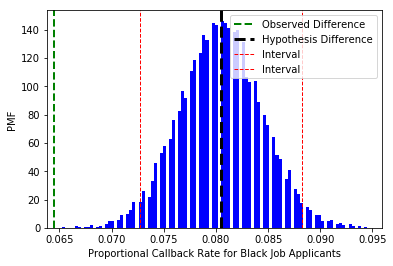

In [22]:
# Create a line for the center of the distribution around the average of the bootstrap replicates
rep_center = np.percentile(replicates,[50])

# Plot the bootstrap replicates as a PMF histogram
bins = 100
_ = plt.hist(replicates, bins=bins, density=True, color='blue')

# Create vertical lines for all the generated data that we collected
obs_mu_line = plt.axvline(working_data.loc[('b','Yes'), 'proportion'], color='green', linestyle='dashed', linewidth=2, label='Observed Difference')
rep_mean_line = plt.axvline(rep_center, color='black', linestyle='dashed', linewidth=3, label='Hypothesis Difference')
interval_low = plt.axvline(confidence_interval_f[0], color='red', linestyle='dashed', linewidth=1, label='Interval')
interval_high = plt.axvline(confidence_interval_f[1], color='red', linestyle='dashed', linewidth=1, label='Interval')
_ = plt.xlabel('Proportional Callback Rate for Black Job Applicants')
_ = plt.ylabel('PMF')
_ = plt.legend(handles=[obs_mu_line, rep_mean_line, interval_low, interval_high], loc='upper right')
plt.show()

#### 4. Write a story describing the statistical significance in the context or the original problem.

How does race affect black and white job applicants in America? This is a question that researchers were curious about when gathering job applicant data from job seekers in the US. Researches based in America looked at race among other factors such as education, number of jobs, and military experience for 4,870 individuals to determine what factors make a significant impact on whether or not employers call back their job applicants.

With the data gathered from these researchers, we are looking to see whether or not black applicants are equally likely to receive a callback from potential employers against their white counterparts. To answer this question, we formed a Null Hypothesis that the proportion of black applicants that received callbacks from potential employers employers was equal to white applicants. Conversely, our Alternative Hypothesis stated that the proportion of callbacks between black and white applicants was not equal. We reject the notion that black and white job applicants are called back equally if the sampled difference is outside the 95% confidence interval given that the two groups are called back equally.

Using our dataset, we separated job applicants between race and callbacks. With four distinct groups (Black and White, Callback or No Callback), we first analyzed our data to see if we can make a normal assumption. For proportional differences, each group has to have a size greater than 10 observations in order to continue.

In [13]:
working_data

count  proportion
race call                   
b    No     2278      0.9355
     Yes     157      0.0645
w    No     2200      0.9035
     Yes     235      0.0965

Looking at our count column, we can see that no grouping has an observation count less than 10 observations. We can then assume that our distribution will be approximately normal. We are also going to assume that the job applicants are operating independently from one another since our sample size is comparably small to the population of total job applicants in America and that the researchers sampled job applicants randomly for our study.

So with these assumptions out of the way, we can now conduct our hypothesis test. We performed the hypothesis test via Bayesian and frequentist methods to compare and validate our test results. 

For the Bayesian approach, we took the proportional difference between black and white callbacks and found the standard error given our sample size. We found that the callback rate for black individuals was around 3.20% less than the callback rate for white individuals with a standard error of .78%. With a 95% confidence interval, the true proportional difference between the callback rate of black and white job applicants is expected to be between 1.53% either way. Since our samples found that black job applicants were called back at a rate less than twice the expected callback rate, we rejected the null hypothesis in favor of the alternative that black and white job applicants are not called back at the same rate. 

To illustrate this point, here is the probability mass function (PMF) of our distribution centered around the zero-difference callback rate. Notice how the observed proportional difference marked in green lies outside our confidence interval marked in red.

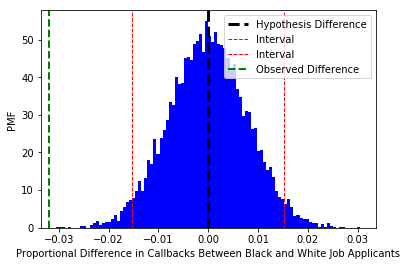

In [14]:
np.random.seed(42)

# Create 10,000 normally distributed  samples centered around the proposed mean and spread given our standard error
bins = 100
samples = np.random.normal(p_not, std_err, 10000)

# Plot the generated points as a histogram with markers indicating confidence interval, mean, and observation
_ = plt.hist(samples, bins=bins, density=True, color='blue')
_ = plt.axvline(p_not, color='black', linestyle='dashed', linewidth=3)
_ = plt.axvline(confidence_interval_b[0], color='red', linestyle='dashed', linewidth=1)
_ = plt.axvline(confidence_interval_b[1], color='red', linestyle='dashed', linewidth=1)
_ = plt.axvline(p_diff, color='green', linestyle='dashed', linewidth=2)
_ = plt.xlabel('Proportional Difference in Callbacks Between Black and White Job Applicants')
_ = plt.ylabel('PMF')
_ = plt.legend(('Hypothesis Difference', 'Interval', 'Interval', 'Observed Difference'), loc='upper right')
plt.show()

To validate our conclusions, we compared our results from the Bayesian approach to Null Hypothesis Testing against our results using the frequentist approach to Null Hypothesis Tests known as bootstrapping. In bootstrapping, we combine and permute the black and white applicant pool to create a new sample of black and white applicants. The idea here is that if we indiscriminately choose applicants and categorize them as black and white applicants, we should get around the same proportion of black callbacks as our observed sample if there is no race discrimination in the hiring process. This proportion of black callbacks (known as our bootstrap replicate) is then taken 10,000 times to create a distribution of proportions that we can base our conclusions from. To illustrate this distribution, here is the PMF after taking 10,000 bootstrap replicates for black callback proportions.

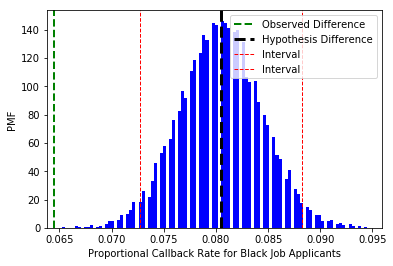

In [21]:
# Create a line for the center of the distribution around the average of the bootstrap replicates
rep_center = np.percentile(replicates,[50])

# Plot the bootstrap replicates as a PMF histogram
bins = 100
_ = plt.hist(replicates, bins=bins, density=True, color='blue')

# Create vertical lines for all the generated data that we collected
obs_mu_line = plt.axvline(working_data.loc[('b','Yes'), 'proportion'], color='green', linestyle='dashed', linewidth=2, label='Observed Difference')
rep_mean_line = plt.axvline(rep_center, color='black', linestyle='dashed', linewidth=3, label='Hypothesis Difference')
interval_low = plt.axvline(confidence_interval_f[0], color='red', linestyle='dashed', linewidth=1, label='Interval')
interval_high = plt.axvline(confidence_interval_f[1], color='red', linestyle='dashed', linewidth=1, label='Interval')
_ = plt.xlabel('Proportional Callback Rate for Black Job Applicants')
_ = plt.ylabel('PMF')
_ = plt.legend(handles=[obs_mu_line, rep_mean_line, interval_low, interval_high], loc='upper right')
plt.show()

After taking 10,000 callback rate samples from our original observation, we find that the average black job applicant callback rate is 8.05% with a standard deviation of 0.39%. With a 95% confidence interval, the true population callback rate for black applicants should be between 7.31% and 8.79%. However, our observations show that black applicants were only being called back from potential employers at a rate of 6.45%. Our tests suggest that if we sample our job applicants indiscriminate of race, our observations outlie far enough to the point where our original assumptions are not true. Therefore, we reject the Null Hypothesis that black and white job applicants are not discriminated during the job application process in favor of the alternative that there exists job discrimination between black and white job applicants.

#### 5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

The test we performed for statistical significance for the callback rate of black and white job applicants does not show that a person's name is the most important factor in the callback success rate; our test only showed that there is a statistically significant difference between black and white sounding names in the job application process. 

In order to find the most important factor for callback success rate with our given dataset, we can perform a Chi Squared Test between the two groups. The Chi Squared Test we would conduct would separate the dataset by race and look at each individual factor provided in the dataset. The expected observation count for each category would be the proportion of people that each factor applies to multiplied by the total number of people in each race. The Chi Squared statistic is the difference between the observation and expected values squared divided by the expected value. The factor with the greatest chi-squared value would be considered the greatest contributor for callback success rate given this particular dataset.